<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 3</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

## 1. Visualize & preprocess

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt, welch
from scipy.ndimage import convolve1d

np.random.seed(42)
random_state = 42

# Paths + results directory
data_folder_name = "Data"
subject_folder_name = "Dataset8"
subject_data_name = "S1_E1_A1.mat"
subject_data_path = os.path.join(data_folder_name, subject_folder_name, subject_data_name)

out_dir = os.path.join(os.getcwd(), "Results", "Part3")
os.makedirs(out_dir, exist_ok=True)

# Load data
data = loadmat(subject_data_path)

emg        = data["emg"]                    # (T, n_channels)
restimulus = data["restimulus"].ravel()     # corrected labels, 1D
rerepetition  = data["rerepetition"].ravel()  # repetition indices, 1D

print("EMG shape:", emg.shape, "| dtype:", emg.dtype)
print("Glove shape:", data["glove"].shape)
print("Unique restimulus:", np.unique(restimulus))
print("Unique rerepetition:", np.unique(rerepetition))

# Select movement-only rows
movement_mask = (restimulus > 0)
row_indices = np.where(movement_mask)[0]

emg_mov = emg[movement_mask, :]  # movement-only EMG

# Joint angles to use (per assignment)
joint_angles_used = [3, 6, 8, 11, 14]
glove_mov = data["glove"][row_indices, :][:, joint_angles_used]  # (T_mov, 5)

print("Movement-only EMG:", emg_mov.shape)
print("Movement-only glove:", glove_mov.shape)

# NinaPro DB1 EMG sampling freq
fs = 100  # Hz

EMG shape: (2292526, 16) | dtype: float32
Glove shape: (2292526, 18)
Unique restimulus: [0 1 2 3 4 5 6 7 8 9]
Unique rerepetition: [ 0  1  2  3  4  5  6  7  8  9 10]
Movement-only EMG: (1104351, 16)
Movement-only glove: (1104351, 5)


### Quick visualizations

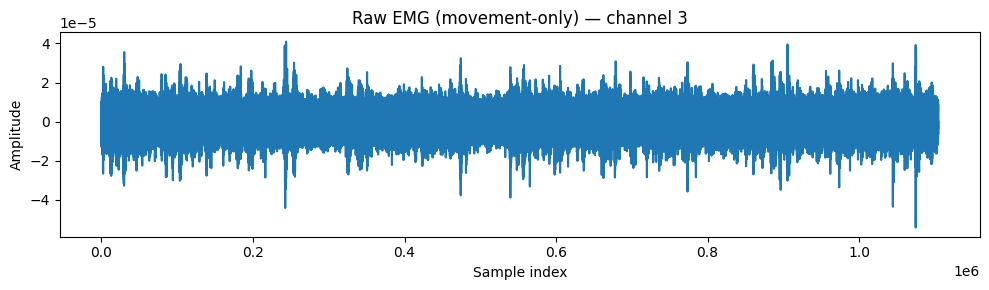

In [2]:
# 1) Raw EMG channel snippet
plt.close("all")
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(emg_mov[:, 3])
ax.set_title("Raw EMG (movement-only) — channel 3")
ax.set_xlabel("Sample index")
ax.set_ylabel("Amplitude")
fig.tight_layout()
fig.savefig(os.path.join(out_dir, "raw_emg_channel3.png"), dpi=200)

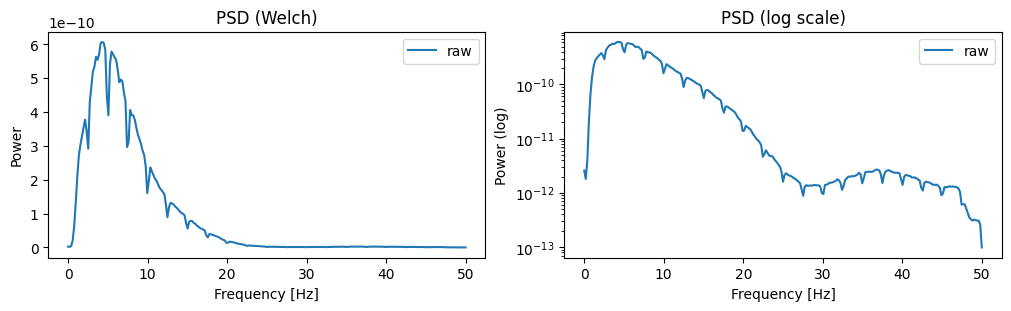

In [3]:
# 2) PSD (Welch) on a raw channel
freqs_pre, Pxx_pre = welch(emg_mov[:, 8], fs=fs, nperseg=512)
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].set_title("PSD (Welch)")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power")
ax[0].legend()

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].set_title("PSD (log scale)")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power (log)")
ax[1].legend()

fig.savefig(os.path.join(out_dir, "psd_raw_channel8.png"), dpi=200)

### Preprocesssing

In [4]:
def bandpass_emg(emg_in, fs, bp=(5, 45), order=4):
    sos = butter(order, bp, btype="bandpass", fs=fs, output="sos")
    return sosfiltfilt(sos, emg_in, axis=0)

def rectified_envelope(emg_filt, window_samples=25):
    # 25 samples @ 100 Hz = 250 ms
    emg_rect = np.abs(emg_filt)
    w = np.ones(window_samples) / window_samples
    return convolve1d(emg_rect, w, axis=0, mode="nearest")

emg_filt = bandpass_emg(emg_mov, fs=fs, bp=(5, 45), order=4)
emg_env  = rectified_envelope(emg_filt, window_samples=25)

print("Envelope shape:", emg_env.shape)

Envelope shape: (1104351, 16)


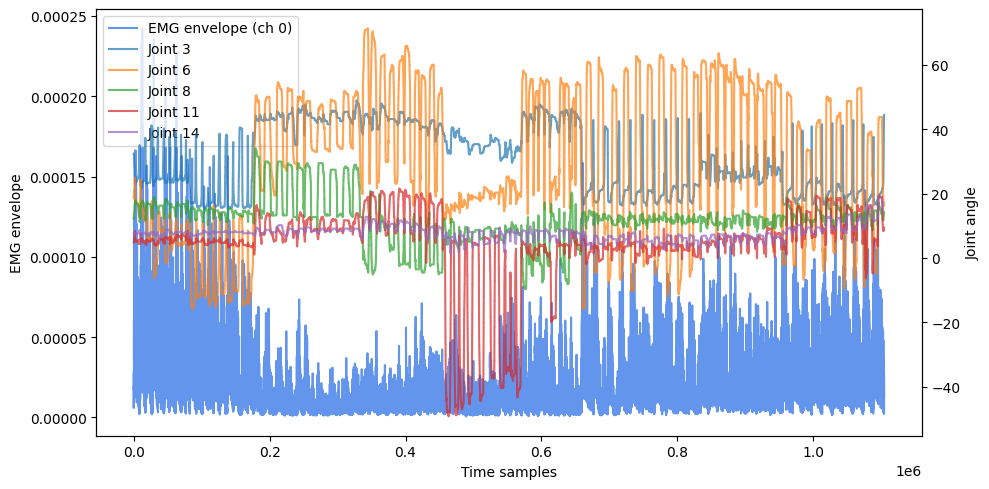

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

# EMG envelope
ax.plot(emg_env[:, 0], color="cornflowerblue", label="EMG envelope (ch 0)")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

# Joint angles (one or several, explicitly labeled)
finger_angle_ax = ax.twinx()
for i, j in enumerate(joint_angles_used):
    finger_angle_ax.plot(
        glove_mov[:, i],
        label=f"Joint {j}",
        alpha=0.7
    )
finger_angle_ax.set_ylabel("Joint angle")
finger_angle_ax.grid(False)

# Combined legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = finger_angle_ax.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()

# Save figure
out_dir = os.path.join(os.getcwd(), "Results", "Part3")
os.makedirs(out_dir, exist_ok=True)
fig.savefig(
    os.path.join(out_dir, "emg_envelope_vs_joint_angles.png"),
    dpi=200,
    bbox_inches="tight"
)


### Time-series split

In [6]:
n = emg_env.shape[0]
i1 = int(0.6 * n)
i2 = int(0.8 * n)

EMG_train, EMG_val, EMG_test = emg_env[:i1], emg_env[i1:i2], emg_env[i2:]
Y_train,   Y_val,   Y_test   = glove_mov[:i1], glove_mov[i1:i2], glove_mov[i2:]

print(f"Train: EMG {EMG_train.shape} | Y {Y_train.shape}")
print(f"Val:   EMG {EMG_val.shape}   | Y {Y_val.shape}")
print(f"Test:  EMG {EMG_test.shape}  | Y {Y_test.shape}")

Train: EMG (662610, 16) | Y (662610, 5)
Val:   EMG (220870, 16)   | Y (220870, 5)
Test:  EMG (220871, 16)  | Y (220871, 5)


## 2. Sliding windows

In [7]:
emg_window_length_sec = 0.200   # 200 ms
window_step_sec       = 0.040   # 40 ms

print("Window length [s]:", emg_window_length_sec, "| step [s]:", window_step_sec)

Window length [s]: 0.2 | step [s]: 0.04


In [8]:
def extract_time_windows_regression(
    EMG: np.ndarray,
    Y: np.ndarray,
    fs: int,
    win_len_sec: float,
    step_sec: float,
):
    """
    Extract overlapping sliding windows for regression.

    Parameters
    ----------
    EMG : array, shape (T, n_channels)
        Preprocessed EMG envelope.
    Y : array, shape (T, n_outputs)
        Continuous targets (joint angles).
    fs : int
        Sampling frequency (Hz).
    win_len_sec : float
        Window length in seconds.
    step_sec : float
        Step size between windows in seconds.

    Returns
    -------
    EMG_windows : array, shape (n_windows, win_len, n_channels)
    Y_windows   : array, shape (n_windows, win_len, n_outputs)

    Notes
    -----
    Targets are later summarized per window (mean joint angle).
    """

    T, n_channels = EMG.shape
    win_len = int(win_len_sec * fs)
    step = int(step_sec * fs)

    start_points = np.arange(0, T - win_len + 1, step)

    EMG_windows = np.zeros((len(start_points), win_len, n_channels))
    Y_windows   = np.zeros((len(start_points), win_len, Y.shape[1]))

    for i, start in enumerate(start_points):
        end = start + win_len
        EMG_windows[i] = EMG[start:end, :]
        Y_windows[i]   = Y[start:end, :]

    return EMG_windows, Y_windows


In [9]:
EMG_train_windows, Y_train_windows = extract_time_windows_regression(
    EMG_train, Y_train, fs,
    emg_window_length_sec,
    window_step_sec
)

EMG_val_windows, Y_val_windows = extract_time_windows_regression(
    EMG_val, Y_val, fs,
    emg_window_length_sec,
    window_step_sec
)

EMG_test_windows, Y_test_windows = extract_time_windows_regression(
    EMG_test, Y_test, fs,
    emg_window_length_sec,
    window_step_sec
)

print("Train windows:", EMG_train_windows.shape, Y_train_windows.shape)
print("Val windows:  ", EMG_val_windows.shape, Y_val_windows.shape)
print("Test windows: ", EMG_test_windows.shape, Y_test_windows.shape)


Train windows: (165648, 20, 16) (165648, 20, 5)
Val windows:   (55213, 20, 16) (55213, 20, 5)
Test windows:  (55213, 20, 16) (55213, 20, 5)


## 3. Extract features

In [10]:
def mav(x):         return np.mean(np.abs(x), axis=0)
def rms(x):         return np.sqrt(np.mean(x**2, axis=0))
def var_feature(x): return np.var(x, axis=0)
def wl(x):          return np.sum(np.abs(np.diff(x, axis=0)), axis=0)
def slope(x):       return np.mean(np.diff(x, axis=0), axis=0)

feature_fns = [mav, rms, var_feature, wl, slope]

In [ ]:
def extract_features_regression(
    EMG_windows: np.ndarray,
    Y_windows: np.ndarray,
    feature_fns,
    fs: int,
    target_shift_sec: float = 0.05,
):
    """
    Extract EMG features per window and predict FUTURE joint angles
    to account for EMG → motion delay.
    """

    X_list = []
    Y_list = []

    shift = int(target_shift_sec * fs)

    for i in range(EMG_windows.shape[0]):
        w = EMG_windows[i]   # (win_len, n_channels)
        y = Y_windows[i]     # (win_len, n_joints)

        # --- Features ---
        feats = [fn(w) for fn in feature_fns]
        X_list.append(np.concatenate(feats))

        # --- Target (shifted forward) ---
        if shift < y.shape[0]:
            y_target = np.mean(y[shift:], axis=0)
        else:
            y_target = np.mean(y, axis=0)

        Y_list.append(y_target)

    return np.vstack(X_list), np.vstack(Y_list)


In [12]:
X_train, Y_train_w = extract_features_regression(
    EMG_train_windows,
    Y_train_windows,
    feature_fns,
    fs=fs,
    target_shift_sec=0.05
)

X_val, Y_val_w = extract_features_regression(
    EMG_val_windows,
    Y_val_windows,
    feature_fns,
    fs=fs,
    target_shift_sec=0.05
)

X_test, Y_test_w = extract_features_regression(
    EMG_test_windows,
    Y_test_windows,
    feature_fns,
    fs=fs,
    target_shift_sec=0.05
)


print("X_train:", X_train.shape, "Y_train:", Y_train_w.shape)
print("X_val:  ", X_val.shape,   "Y_val:  ", Y_val_w.shape)
print("X_test: ", X_test.shape,  "Y_test: ", Y_test_w.shape)


X_train: (165648, 80) Y_train: (165648, 5)
X_val:   (55213, 80) Y_val:   (55213, 5)
X_test:  (55213, 80) Y_test:  (55213, 5)


## 4. Gradient Boosting

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Normalize features (fit on train only)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)

In [14]:
temporal_context = True  # Set to True to enable temporal context

if temporal_context:
    def add_temporal_context(X, lag=1):
        X_prev = np.vstack([X[0], X[:-1]])
        X_next = np.vstack([X[1:], X[-1]])
        return np.hstack([X_prev, X, X_next])

    X_train_z = add_temporal_context(X_train_z)
    X_val_z   = add_temporal_context(X_val_z)
    X_test_z  = add_temporal_context(X_test_z)

In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

hgb_params = dict(
    max_iter=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=random_state
)

models = []
for j in range(Y_train_w.shape[1]):
    print(f"Training separate model {j+1}/{Y_train_w.shape[1]} (one per joint).")
    m = HistGradientBoostingRegressor(**hgb_params)
    m.fit(X_train_z, Y_train_w[:, j])
    models.append(m)


Y_val_pred  = np.column_stack([models[j].predict(X_val_z)  for j in range(len(models))])
Y_test_pred = np.column_stack([models[j].predict(X_test_z) for j in range(len(models))])

rmse_val_per_joint = np.sqrt(mean_squared_error(Y_val_w, Y_val_pred, multioutput="raw_values"))
rmse_test_per_joint = np.sqrt(mean_squared_error(Y_test_w, Y_test_pred, multioutput="raw_values"))
print("Validation RMSE per joint:", rmse_val_per_joint)
print("Validation mean RMSE:", rmse_val_per_joint.mean())


Training separate model 1/5 (one per joint).
Training separate model 2/5 (one per joint).
Training separate model 3/5 (one per joint).
Training separate model 4/5 (one per joint).
Training separate model 5/5 (one per joint).
Validation RMSE per joint: [11.54887627 32.04129459  4.29771957  5.5076076   2.75598035]
Validation mean RMSE: 11.230295676342987


### Test evaluation

In [21]:
import pandas as pd

rmse_val  = np.sqrt(mean_squared_error(Y_val_w,  Y_val_pred,  multioutput="raw_values"))
rmse_test = np.sqrt(mean_squared_error(Y_test_w, Y_test_pred, multioutput="raw_values"))
mae_test  = mean_absolute_error(Y_test_w, Y_test_pred, multioutput="raw_values")
r2_test   = r2_score(Y_test_w, Y_test_pred, multioutput="raw_values")

df = pd.DataFrame({
    "joint_id": joint_angles_used,
    "rmse_val": rmse_val,
    "rmse_test": rmse_test,
    "mae_test": mae_test,
    "r2_test": r2_test,
})

# Add mean row
df_mean = pd.DataFrame([{
    "joint_id": "MEAN",
    "rmse_val": rmse_val.mean(),
    "rmse_test": rmse_test.mean(),
    "mae_test": mae_test.mean(),
    "r2_test": r2_test.mean(),
}])
df = pd.concat([df, df_mean], ignore_index=True)

out_csv = os.path.join(out_dir, "part3_separate_models_metrics.csv")
df.to_csv(out_csv, index=False)
print("Saved metrics to:", out_csv)
print(df)

Saved metrics to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_separate_models_metrics.csv
  joint_id   rmse_val  rmse_test   mae_test   r2_test
0        3  11.548876  10.001231   8.261900 -2.775389
1        6  32.041295  26.393606  21.783177 -0.471790
2        8   4.297720   4.817239   3.688811 -4.673924
3       11   5.507608   8.975228   6.773089 -1.898655
4       14   2.755980   3.404915   2.406619 -0.200998
5     MEAN  11.230296  10.718444   8.582719 -2.004151


### Plot predictions

Saved plot to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_separate_models_true_vs_pred.png


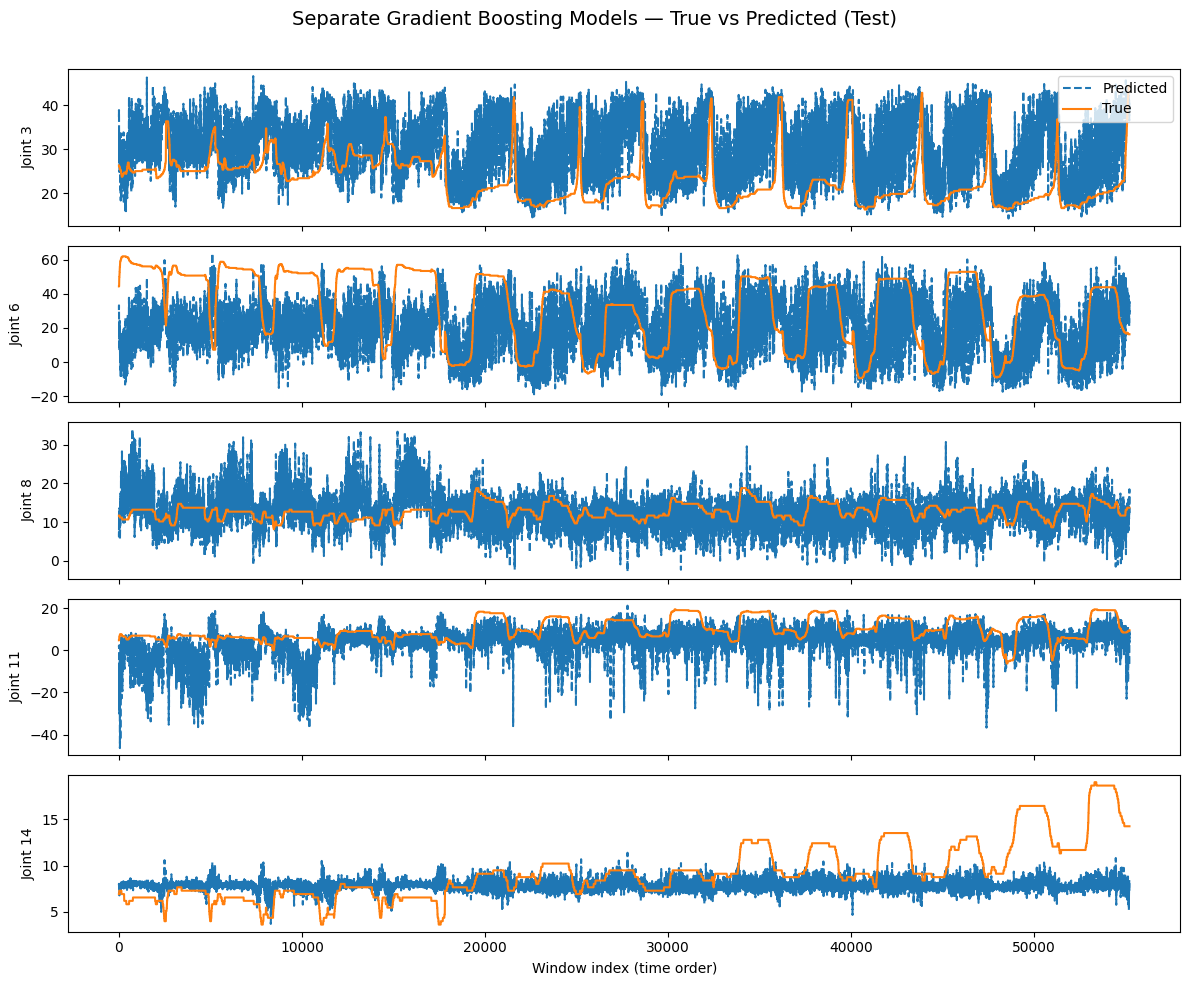

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(joint_angles_used), 1, figsize=(12, 10), sharex=True)
fig.suptitle("Separate Gradient Boosting Models — True vs Predicted (Test)", fontsize=14)

for k, joint_id in enumerate(joint_angles_used):
    ax = axes[k]
    ax.plot(Y_test_pred[:, k], linestyle="--", label="Predicted")
    ax.plot(Y_test_w[:, k], label="True")
    ax.set_ylabel(f"Joint {joint_id}")
    if k == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Window index (time order)")
fig.tight_layout(rect=[0, 0, 1, 0.97])

fig_path = os.path.join(out_dir, "part3_separate_models_true_vs_pred.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved plot to:", fig_path)


### Stability plot (RMSE per joint)

Saved RMSE-per-joint plot to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_rmse_per_joint.png


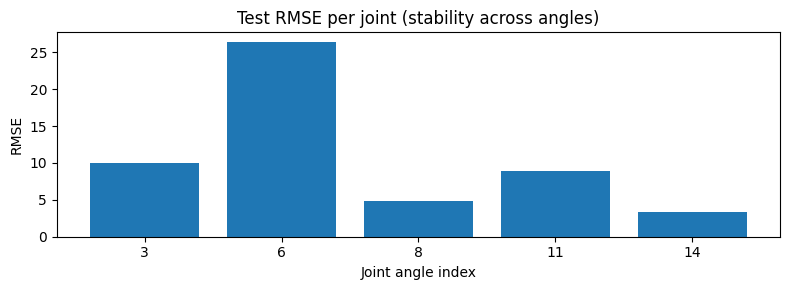

In [24]:
plt.close("all")
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar([str(j) for j in joint_angles_used], rmse_test_per_joint)
ax.set_title("Test RMSE per joint (stability across angles)")
ax.set_xlabel("Joint angle index")
ax.set_ylabel("RMSE")
fig.tight_layout()
bar_path = os.path.join(out_dir, "part3_rmse_per_joint.png")
fig.savefig(bar_path, dpi=200, bbox_inches="tight")
print(f"Saved RMSE-per-joint plot to: {bar_path}")